<a href="https://colab.research.google.com/github/HariharanV11/Stock-price-Prediction/blob/main/SVR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2023-11-09 00:00:00+00:00  181.281906  182.410004  184.119995  181.809998   
2023-11-10 00:00:00+00:00  185.491272  186.399994  186.570007  183.529999   
2023-11-13 00:00:00+00:00  183.899063  184.800003  186.029999  184.210007   
2023-11-14 00:00:00+00:00  186.526215  187.440002  188.110001  186.300003   
2023-11-15 00:00:00+00:00  187.093414  188.009995  189.500000  187.779999   
...                               ...         ...         ...         ...   
2024-11-04 00:00:00+00:00  221.766006  222.009995  222.789993  219.710007   
2024-11-05 00:00:00+00:00  223.204422  223.449997  223.949997  221.139999   
2024-11-06 00:00:00+00:00  222.475235  222.720001  226.070007  221.190002   
2024-11-07 00:00:00+00:00  227.229996  227.479996  227.880005  224.570007   

<ipython-input-1-fe866779c721>:95: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return dates, X.astype(np.float32), Y.astype(np.float32)


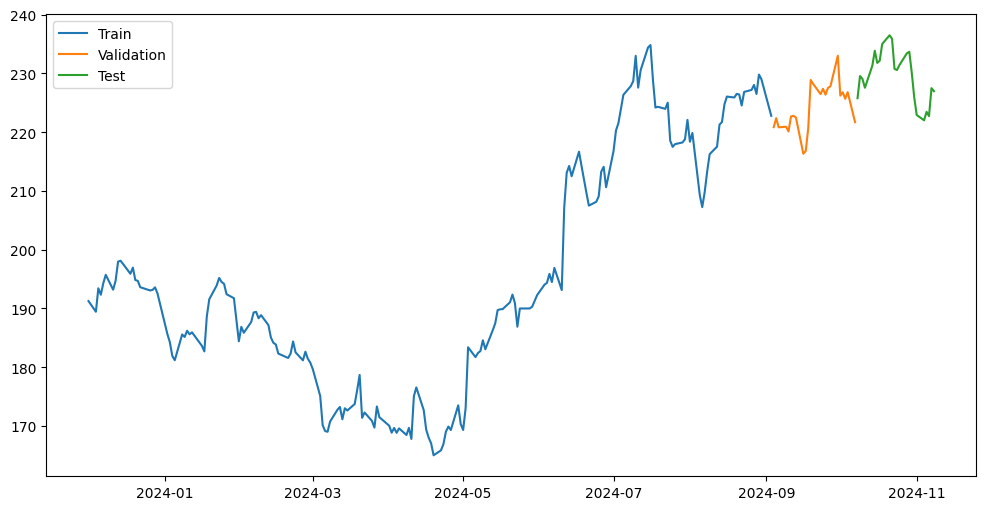

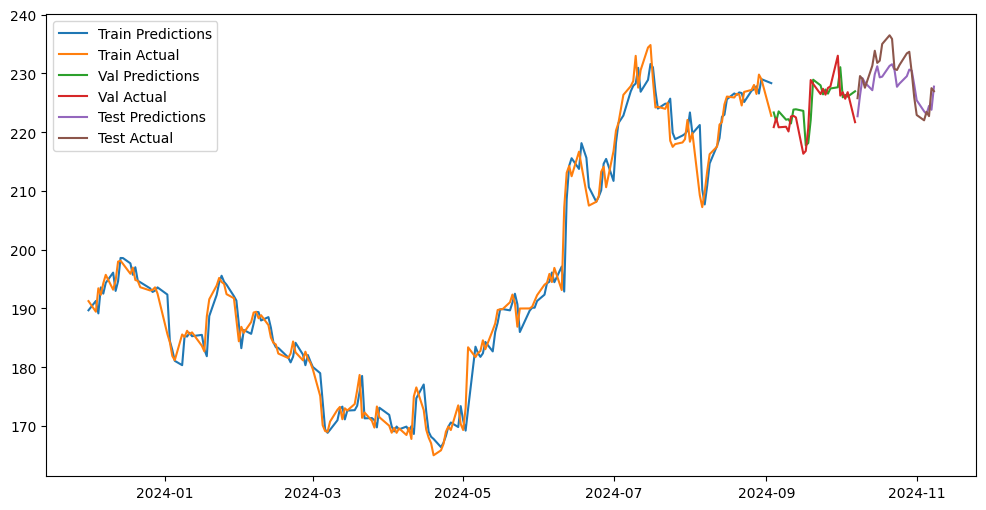

<ipython-input-1-fe866779c721>:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_prediction  # Slide window to include the latest prediction
<ipython-input-1-fe866779c721>:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_prediction  # Slide window to include the latest prediction
<ipython-input-1-fe866779c721>:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_prediction  # Slide window to incl

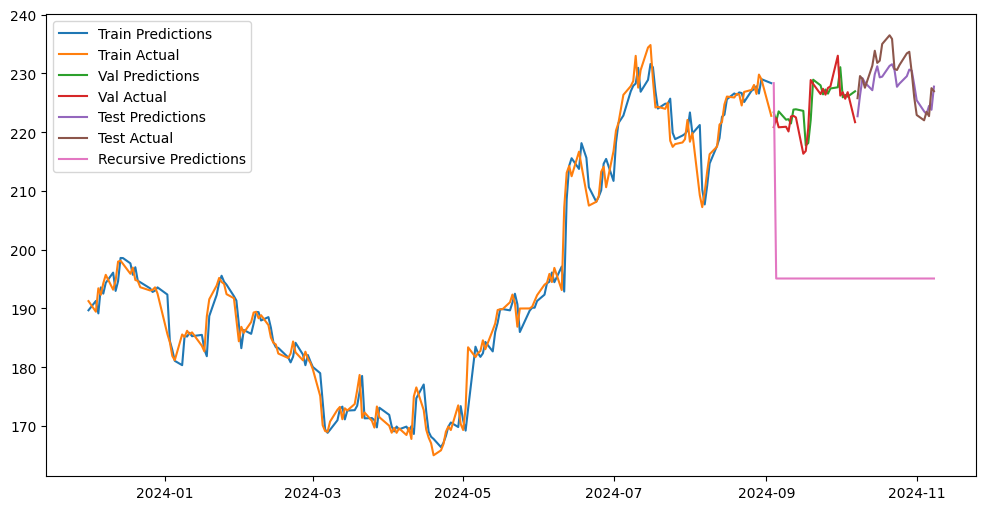

In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR  # Import Support Vector Regression (SVR) from scikit-learn
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import yfinance as yf

# Fetch historical data for the last 1 year for 'AAPL'
ticker = 'AAPL'
df = yf.download(ticker, period="1y")  # '1y' stands for 1 year

# Display the data
print(df)

# Reset index and select required columns
df = df.reset_index()
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])  # Convert Date to datetime format

# Ensure the 'Date' column is timezone-naive (removes timezone information if any)
df['Date'] = df['Date'].dt.tz_localize(None)  # This removes any timezone information if present

# Set 'Date' as index again after making sure it's timezone-naive
df.set_index('Date', inplace=True)

# Function to convert string to datetime (for compatibility)
def str_to_datetime(s):
    year, month, day = map(int, s.split('-'))
    return datetime.datetime(year=year, month=month, day=day)

# Windowing function
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    last_time = False
    while True:
        # Slice data up to the target_date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return None  # Return None if window size is too large

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Move to next date
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        if next_week.empty:
            break
        next_datetime_str = str(next_week.head(2).tail(1).index[0])
        next_date_str = next_datetime_str.split('T')[0]
        next_date = pd.to_datetime(next_date_str)

        if last_time:
            break

        target_date = next_date
        if target_date >= last_date:
            last_time = True

    ret_df = pd.DataFrame({})  # Convert to DataFrame
    ret_df['Target Date'] = dates
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    ret_df['Target'] = Y

    return ret_df

# Generate windowed data
windowed_df = df_to_windowed_df(df, '2023-12-01', '2024-11-08', n=3)

# Check if the windowed_df is None (i.e., the function couldn't generate valid windows)
if windowed_df is None:
    print("Unable to generate windowed data due to insufficient data.")
else:
    # Separate features and labels
    def windowed_df_to_date_X_y(windowed_dataframe):
        df_as_np = windowed_dataframe.to_numpy()
        dates = df_as_np[:, 0]
        middle_matrix = df_as_np[:, 1:-1]
        X = middle_matrix.reshape((len(dates), middle_matrix.shape[1]))
        Y = df_as_np[:, -1]
        return dates, X.astype(np.float32), Y.astype(np.float32)

    dates, X, y = windowed_df_to_date_X_y(windowed_df)

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data into train, validation, and test sets
    q_80 = int(len(dates) * 0.8)
    q_90 = int(len(dates) * 0.9)

    dates_train, X_train, y_train = dates[:q_80], X_scaled[:q_80], y[:q_80]
    dates_val, X_val, y_val = dates[q_80:q_90], X_scaled[q_80:q_90], y[q_80:q_90]
    dates_test, X_test, y_test = dates[q_90:], X_scaled[q_90:], y[q_90:]

    # Plotting train, validation, and test sets
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, y_test)
    plt.legend(['Train', 'Validation', 'Test'])
    plt.show()

    # Model definition using SVM
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

    # Training the SVM model
    model.fit(X_train, y_train)

    # Predictions
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)
    test_predictions = model.predict(X_test)

    # Plot predictions and actual values
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Train Predictions', 'Train Actual', 'Val Predictions', 'Val Actual', 'Test Predictions', 'Test Actual'])
    plt.show()

    # Recursive predictions
    recursive_predictions = []
    recursive_dates = np.concatenate([dates_val, dates_test])
    last_window = deepcopy(X_train[-1])

    for _ in recursive_dates:
        next_prediction = model.predict([last_window])
        recursive_predictions.append(next_prediction)
        last_window = np.roll(last_window, -1)
        last_window[-1] = next_prediction  # Slide window to include the latest prediction

    # Plot recursive predictions
    plt.figure(figsize=(12, 6))
    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.plot(recursive_dates, recursive_predictions)
    plt.legend(['Train Predictions', 'Train Actual', 'Val Predictions', 'Val Actual', 'Test Predictions', 'Test Actual', 'Recursive Predictions'])
    plt.show()


[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2023-11-09 00:00:00+00:00  181.281891  182.410004  184.119995  181.809998   
2023-11-10 00:00:00+00:00  185.491272  186.399994  186.570007  183.529999   
2023-11-13 00:00:00+00:00  183.899063  184.800003  186.029999  184.210007   
2023-11-14 00:00:00+00:00  186.526199  187.440002  188.110001  186.300003   
2023-11-15 00:00:00+00:00  187.093430  188.009995  189.500000  187.779999   
...                               ...         ...         ...         ...   
2024-11-04 00:00:00+00:00  221.766006  222.009995  222.789993  219.710007   
2024-11-05 00:00:00+00:00  223.204422  223.449997  223.949997  221.139999   
2024-11-06 00:00:00+00:00  222.475235  222.720001  226.070007  221.190002   
2024-11-07 00:00:00+00:00  227.229996  227.479996  227.880005  224.570007   

<ipython-input-3-2b88f05076db>:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return dates, X.astype(np.float32), Y.astype(np.float32)


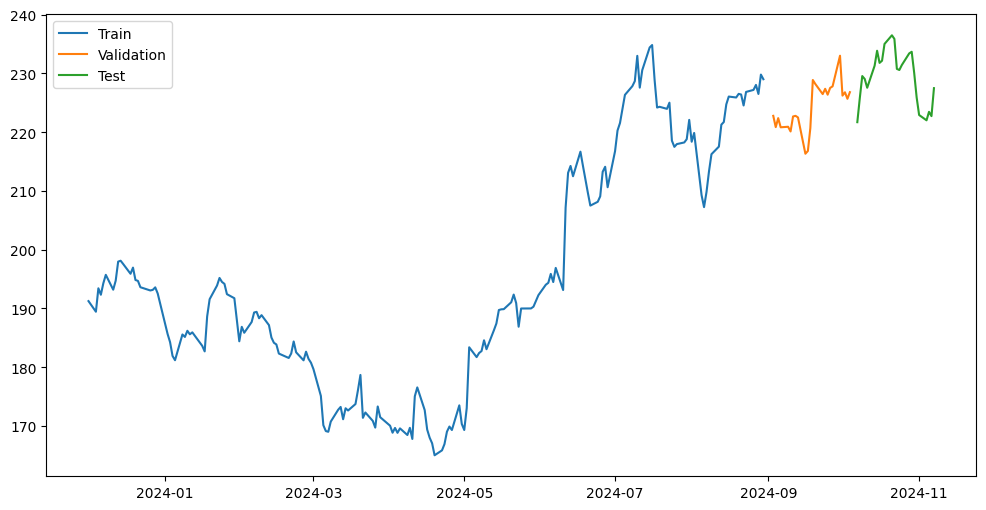

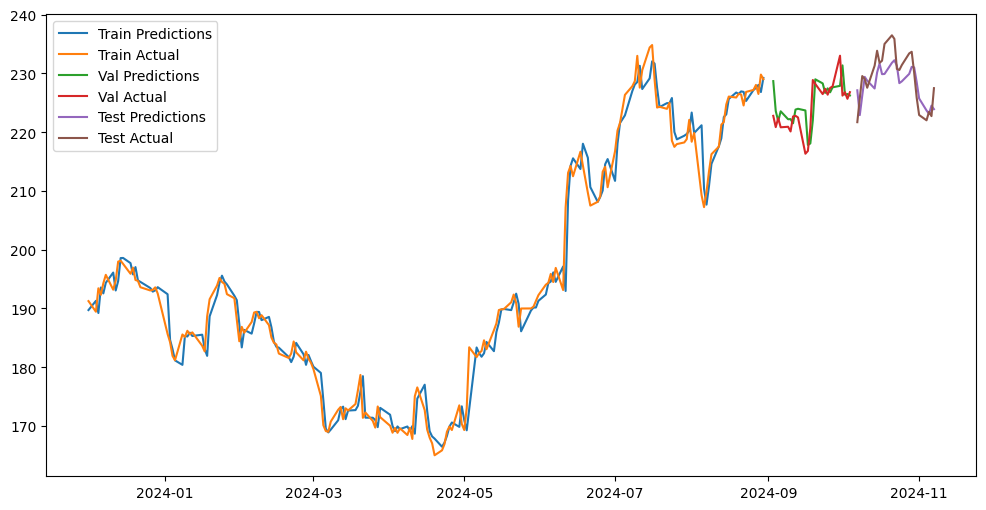

<ipython-input-3-2b88f05076db>:148: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_prediction  # Slide window to include the latest prediction
<ipython-input-3-2b88f05076db>:148: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_prediction  # Slide window to include the latest prediction
<ipython-input-3-2b88f05076db>:148: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = next_prediction  # Slide window to incl

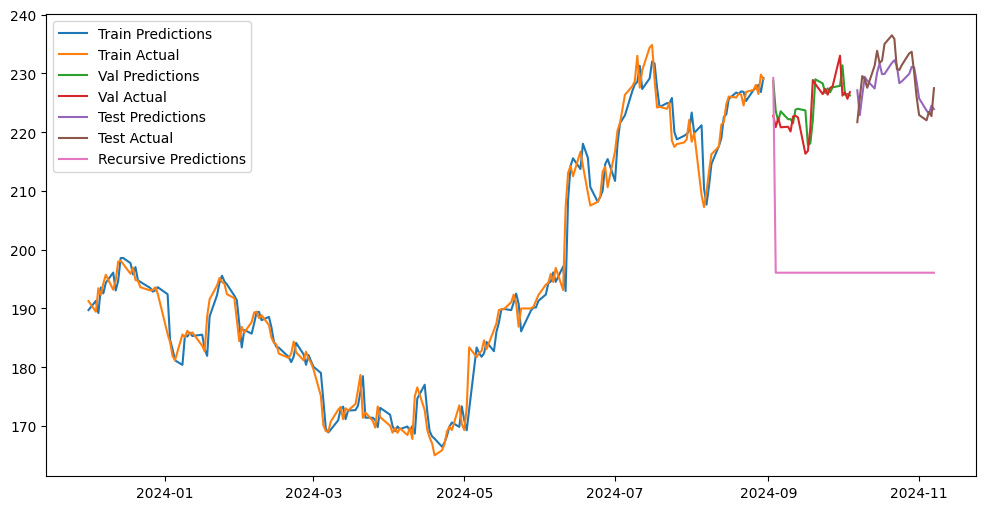

In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR  # Import Support Vector Regression (SVR) from scikit-learn
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import yfinance as yf

# Fetch historical data for the last 1 year for 'AAPL'
ticker = 'AAPL'
df = yf.download(ticker, period="1y")  # '1y' stands for 1 year

# Check if the data is empty
if df.empty:
    print(f"No data fetched for ticker {ticker}")
else:
    # Display the data
    print(df)

    # Reset index and select required columns
    df = df.reset_index()
    df = df[['Date', 'Close']]
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date to datetime format

    # Ensure the 'Date' column is timezone-naive (removes timezone information if any)
    df['Date'] = df['Date'].dt.tz_localize(None)  # This removes any timezone information if present

    # Set 'Date' as index again after making sure it's timezone-naive
    df.set_index('Date', inplace=True)

    # Function to convert string to datetime (for compatibility)
    def str_to_datetime(s):
        year, month, day = map(int, s.split('-'))
        return datetime.datetime(year=year, month=month, day=day)

    # Windowing function
    def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
        first_date = str_to_datetime(first_date_str)
        last_date = str_to_datetime(last_date_str)

        target_date = first_date
        dates = []
        X, Y = [], []

        last_time = False
        while True:
            # Slice data up to the target_date
            df_subset = dataframe.loc[:target_date].tail(n+1)
            if len(df_subset) != n+1:
                print(f'Error: Window of size {n} is too large for date {target_date}')
                return None  # Return None if window size is too large

            values = df_subset['Close'].to_numpy()
            x, y = values[:-1], values[-1]

            dates.append(target_date)
            X.append(x)
            Y.append(y)

            # Move to next available date
            next_day = dataframe.index[dataframe.index.get_loc(target_date) + 1] if len(dataframe.index) > dataframe.index.get_loc(target_date) + 1 else None
            if next_day is None:
                break

            target_date = next_day
            if target_date >= last_date:
                break

        ret_df = pd.DataFrame({})  # Convert to DataFrame
        ret_df['Target Date'] = dates
        X = np.array(X)
        for i in range(n):
            ret_df[f'Target-{n-i}'] = X[:, i]
        ret_df['Target'] = Y

        return ret_df

    # Generate windowed data
    windowed_df = df_to_windowed_df(df, '2023-12-01', '2024-11-08', n=3)

    # Check if the windowed_df is None (i.e., the function couldn't generate valid windows)
    if windowed_df is None:
        print("Unable to generate windowed data due to insufficient data.")
    else:
        # Separate features and labels
        def windowed_df_to_date_X_y(windowed_dataframe):
            df_as_np = windowed_dataframe.to_numpy()
            dates = df_as_np[:, 0]
            middle_matrix = df_as_np[:, 1:-1]
            X = middle_matrix.reshape((len(dates), middle_matrix.shape[1]))
            Y = df_as_np[:, -1]
            return dates, X.astype(np.float32), Y.astype(np.float32)

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        # Normalize the features using StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Split data into train, validation, and test sets
        q_80 = int(len(dates) * 0.8)
        q_90 = int(len(dates) * 0.9)

        dates_train, X_train, y_train = dates[:q_80], X_scaled[:q_80], y[:q_80]
        dates_val, X_val, y_val = dates[q_80:q_90], X_scaled[q_80:q_90], y[q_80:q_90]
        dates_test, X_test, y_test = dates[q_90:], X_scaled[q_90:], y[q_90:]

        # Plotting train, validation, and test sets
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, y_test)
        plt.legend(['Train', 'Validation', 'Test'])
        plt.show()

        # Model definition using SVM
        model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

        # Training the SVM model
        model.fit(X_train, y_train)

        # Predictions
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)
        test_predictions = model.predict(X_test)

        # Plot predictions and actual values
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_predictions)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_predictions)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_predictions)
        plt.plot(dates_test, y_test)
        plt.legend(['Train Predictions', 'Train Actual', 'Val Predictions', 'Val Actual', 'Test Predictions', 'Test Actual'])
        plt.show()

        # Recursive predictions
        recursive_predictions = []
        recursive_dates = np.concatenate([dates_val, dates_test])
        last_window = deepcopy(X_train[-1])

        for _ in recursive_dates:
            next_prediction = model.predict([last_window])
            recursive_predictions.append(next_prediction)
            last_window = np.roll(last_window, -1)
            last_window[-1] = next_prediction  # Slide window to include the latest prediction

        # Plot recursive predictions
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_predictions)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_predictions)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_predictions)
        plt.plot(dates_test, y_test)
        plt.plot(recursive_dates, recursive_predictions)
        plt.legend(['Train Predictions', 'Train Actual', 'Val Predictions', 'Val Actual', 'Test Predictions', 'Test Actual', 'Recursive Predictions'])
        plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for train, validation, and test sets
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_mae = mean_absolute_error(y_train, train_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

# Print out the MSE and MAE for each set
print(f"Train MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")
print(f"Test MAE: {test_mae}")


Train MSE: 8.038498416567599
Validation MSE: 9.583982265115809
Test MSE: 8.828882785539117
Train MAE: 1.9586188771720632
Validation MAE: 2.256624847602142
Test MAE: 2.580320271202224


[*********************100%***********************]  1 of 1 completed


Price                       Adj Close       Close        High         Low  \
Ticker                           AAPL        AAPL        AAPL        AAPL   
Date                                                                        
2023-11-09 00:00:00+00:00  181.281906  182.410004  184.119995  181.809998   
2023-11-10 00:00:00+00:00  185.491272  186.399994  186.570007  183.529999   
2023-11-13 00:00:00+00:00  183.899063  184.800003  186.029999  184.210007   
2023-11-14 00:00:00+00:00  186.526199  187.440002  188.110001  186.300003   
2023-11-15 00:00:00+00:00  187.093414  188.009995  189.500000  187.779999   
...                               ...         ...         ...         ...   
2024-11-04 00:00:00+00:00  221.766006  222.009995  222.789993  219.710007   
2024-11-05 00:00:00+00:00  223.204422  223.449997  223.949997  221.139999   
2024-11-06 00:00:00+00:00  222.475235  222.720001  226.070007  221.190002   
2024-11-07 00:00:00+00:00  227.229996  227.479996  227.880005  224.570007   

<ipython-input-5-a13d79ae2a16>:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return dates, X.astype(np.float32), Y.astype(np.float32)


Support Vectors:
[[-0.46740636 -0.52042031 -0.49942002]
 [-0.51493865 -0.4937048  -0.4400951 ]
 [-0.4881728  -0.43428558 -0.52333397]
 [-0.42864156 -0.51765674 -0.33984163]
 [-0.5121699  -0.33387277 -0.39042798]
 [-0.32803947 -0.38453951 -0.30075157]
 [-0.37880173 -0.29472056 -0.23452874]
 [-0.28881344 -0.22839247 -0.35087901]
 [-0.22236033 -0.34492767 -0.28051671]
 [-0.33911523 -0.27445355 -0.13105574]
 [-0.26850826 -0.12475499 -0.12415782]
 [-0.11852749 -0.1178461  -0.14899103]
 [-0.11160558 -0.14271879 -0.22625123]
 [-0.13652515 -0.2201018  -0.17796369]
 [-0.21405405 -0.17173751 -0.2749984 ]
 [-0.16559857 -0.26892644 -0.28189701]
 [-0.26297072 -0.27583602 -0.33156344]
 [-0.26989335 -0.3255814  -0.35685697]
 [-0.31973246 -0.35091513 -0.35225859]
 [-0.34511396 -0.34630945 -0.33248338]
 [-0.34049961 -0.32650283 -0.38077089]
 [-0.32065561 -0.37486708 -0.69762814]
 [-0.36911109 -0.69222802 -0.76155144]
 [-0.68707019 -0.75625288 -0.86916322]
 [-0.75121582 -0.86403567 -0.90273494]
 [-0.859

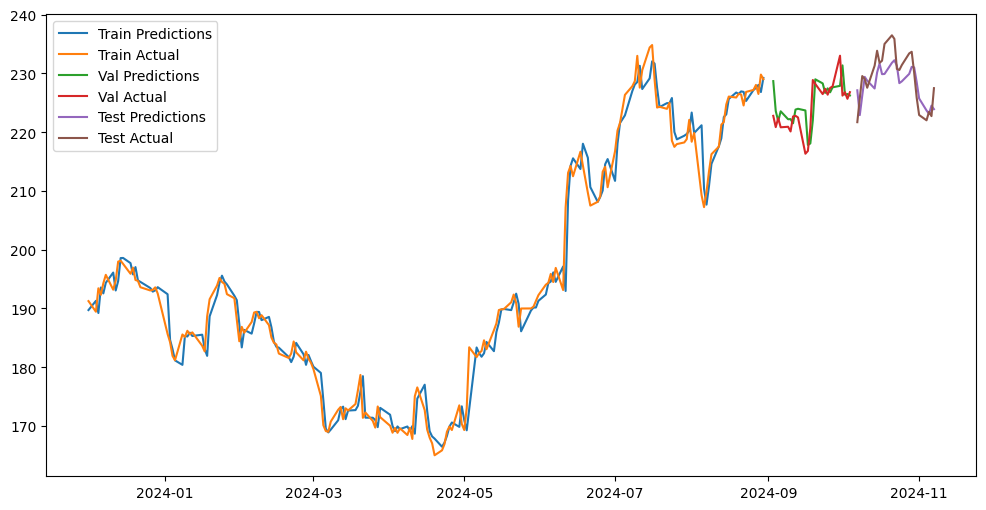

In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR  # Import Support Vector Regression (SVR) from scikit-learn
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import yfinance as yf

# Fetch historical data for the last 1 year for 'AAPL'
ticker = 'AAPL'
df = yf.download(ticker, period="1y")  # '1y' stands for 1 year

# Check if the data is empty
if df.empty:
    print(f"No data fetched for ticker {ticker}")
else:
    # Display the data
    print(df)

    # Reset index and select required columns
    df = df.reset_index()
    df = df[['Date', 'Close']]
    df['Date'] = pd.to_datetime(df['Date'])  # Convert Date to datetime format

    # Ensure the 'Date' column is timezone-naive (removes timezone information if any)
    df['Date'] = df['Date'].dt.tz_localize(None)  # This removes any timezone information if present

    # Set 'Date' as index again after making sure it's timezone-naive
    df.set_index('Date', inplace=True)

    # Function to convert string to datetime (for compatibility)
    def str_to_datetime(s):
        year, month, day = map(int, s.split('-'))
        return datetime.datetime(year=year, month=month, day=day)

    # Windowing function
    def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
        first_date = str_to_datetime(first_date_str)
        last_date = str_to_datetime(last_date_str)

        target_date = first_date
        dates = []
        X, Y = [], []

        last_time = False
        while True:
            # Slice data up to the target_date
            df_subset = dataframe.loc[:target_date].tail(n+1)
            if len(df_subset) != n+1:
                print(f'Error: Window of size {n} is too large for date {target_date}')
                return None  # Return None if window size is too large

            values = df_subset['Close'].to_numpy()
            x, y = values[:-1], values[-1]

            dates.append(target_date)
            X.append(x)
            Y.append(y)

            # Move to next available date
            next_day = dataframe.index[dataframe.index.get_loc(target_date) + 1] if len(dataframe.index) > dataframe.index.get_loc(target_date) + 1 else None
            if next_day is None:
                break

            target_date = next_day
            if target_date >= last_date:
                break

        ret_df = pd.DataFrame({})  # Convert to DataFrame
        ret_df['Target Date'] = dates
        X = np.array(X)
        for i in range(n):
            ret_df[f'Target-{n-i}'] = X[:, i]
        ret_df['Target'] = Y

        return ret_df

    # Generate windowed data
    windowed_df = df_to_windowed_df(df, '2023-12-01', '2024-11-08', n=3)

    # Check if the windowed_df is None (i.e., the function couldn't generate valid windows)
    if windowed_df is None:
        print("Unable to generate windowed data due to insufficient data.")
    else:
        # Separate features and labels
        def windowed_df_to_date_X_y(windowed_dataframe):
            df_as_np = windowed_dataframe.to_numpy()
            dates = df_as_np[:, 0]
            middle_matrix = df_as_np[:, 1:-1]
            X = middle_matrix.reshape((len(dates), middle_matrix.shape[1]))
            Y = df_as_np[:, -1]
            return dates, X.astype(np.float32), Y.astype(np.float32)

        dates, X, y = windowed_df_to_date_X_y(windowed_df)

        # Normalize the features using StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Split data into train, validation, and test sets
        q_80 = int(len(dates) * 0.8)
        q_90 = int(len(dates) * 0.9)

        dates_train, X_train, y_train = dates[:q_80], X_scaled[:q_80], y[:q_80]
        dates_val, X_val, y_val = dates[q_80:q_90], X_scaled[q_80:q_90], y[q_80:q_90]
        dates_test, X_test, y_test = dates[q_90:], X_scaled[q_90:], y[q_90:]

        # Model definition using SVM
        model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.01)

        # Training the SVM model
        model.fit(X_train, y_train)

        # Display the support vectors and coefficients
        print("Support Vectors:")
        print(model.support_vectors_)

        print("\nDual Coefficients:")
        print(model.dual_coef_)

        print("\nIntercept (b) value:")
        print(model.intercept_)

        # Calculate and display the learned equation for the SVM
        # The equation is more complex with RBF kernel, but we can explain the coefficients
        # based on support vectors and dual coefficients
        print("\nEquation (not a simple linear equation due to RBF kernel):")
        print("y = sum(alpha_i * K(x_i, x) + b)")
        print("where:")
        print("alpha_i = dual coefficients (coefficients of support vectors)")
        print("K(x_i, x) = RBF kernel function between support vector x_i and input x")
        print("b = intercept value")

        # Predict values
        train_predictions = model.predict(X_train)
        val_predictions = model.predict(X_val)
        test_predictions = model.predict(X_test)

        # Plotting predictions and actual values
        plt.figure(figsize=(12, 6))
        plt.plot(dates_train, train_predictions)
        plt.plot(dates_train, y_train)
        plt.plot(dates_val, val_predictions)
        plt.plot(dates_val, y_val)
        plt.plot(dates_test, test_predictions)
        plt.plot(dates_test, y_test)
        plt.legend(['Train Predictions', 'Train Actual', 'Val Predictions', 'Val Actual', 'Test Predictions', 'Test Actual'])
        plt.show()



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE for train, validation, and test sets
train_mse = mean_squared_error(y_train, train_predictions)
val_mse = mean_squared_error(y_val, val_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_mae = mean_absolute_error(y_train, train_predictions)
val_mae = mean_absolute_error(y_val, val_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

# Print out the MSE and MAE for each set
print(f"Train MSE: {train_mse}")
print(f"Validation MSE: {val_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")
print(f"Test MAE: {test_mae}")


Train MSE: 8.038498416567599
Validation MSE: 9.583982265115809
Test MSE: 8.828882785539117
Train MAE: 1.9586188771720632
Validation MAE: 2.256624847602142
Test MAE: 2.580320271202224
